# My first simulation

As introduction to the `rumdpy` package let us setting up a simulation
of a Lennard-Jones FCC crystal in the constant $NVT$ ensemble.
For a short summary, see the [minimal.py](../examples/minimal.py) example script.

If `rumdpy` is installed correctly, the following package should be imported without any errors. It is recommended to import the package as `rp`.

In [1]:
import rumdpy as rp

We will also import NumPy for numerical calculations and Matplotlib for plotting.

In [2]:
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting

## Initial particle positions

We wish to set up a configuration of a FCC lattice with $8 \times 8 \times 8$ unit cells, with a density of $\rho = 0.973$. First we create an empty configuration object.

In [3]:
configuration = rp.Configuration()

Information for a few crystal unit cells are avalible with the `rumdpy` package. For example, the FCC unit cell is stored as `rp.unit_cells.FCC`.

In [4]:
rp.unit_cells.FCC

{'fractional_coordinates': [[0.0, 0.0, 0.0],
  [0.5, 0.5, 0.0],
  [0.5, 0.0, 0.5],
  [0.0, 0.5, 0.5]],
 'lattice_constants': [1.0, 1.0, 1.0]}

We use the `make_lattice` method to assign positions and a simulation box to the  configuration object.

In [5]:
# Setup configuration: FCC Lattice
configuration.make_lattice(
    unit_cell=rp.unit_cells.FCC, 
    cells=[8, 8, 8],
    rho=0.973
)

The positions can be accessed with `['r']`. All vector properties, like the positions, are NumPy arrays.

In [6]:
positions = configuration['r']
type(positions)

numpy.ndarray

To confirm that the positions are as expected, we can visualize the configuration using Matplotlib. 

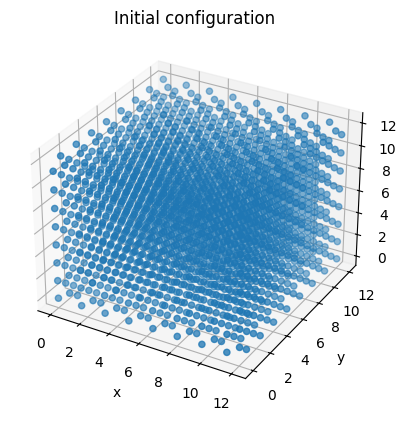

In [7]:
# Make 3D plot using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Initial configuration')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

The configuration object also contains information about the simulation box. The box lengths can be accessed with the `lengths` attribute.

In [8]:
configuration.simbox.lengths  # Box lengths

array([12.815602, 12.815602, 12.815602], dtype=float32)

## Masses and initial velocities

We set all particle masses to one.

In [9]:
configuration['m'] = 1.0  # Set all masses to 1.0

Note that `configuration['m']` refer to an NumPy array. For convenience, we above used a `float` to set all masses to the same value. This value will automatically be broadcast to all particles.

In [10]:
type(configuration['m'])  # configuration['m'] is a NumPy array

numpy.ndarray

After masses are set, we can assign random velocities corresponding to an initial kinetic temperature $T = 0.8$.

In [11]:
temperature = 0.8
configuration.randomize_velocities(T=temperature)

To confirm that the initial velocity distribution is as expected, we can compare it the the theoretical Maxwell-Boltzmann distribution.

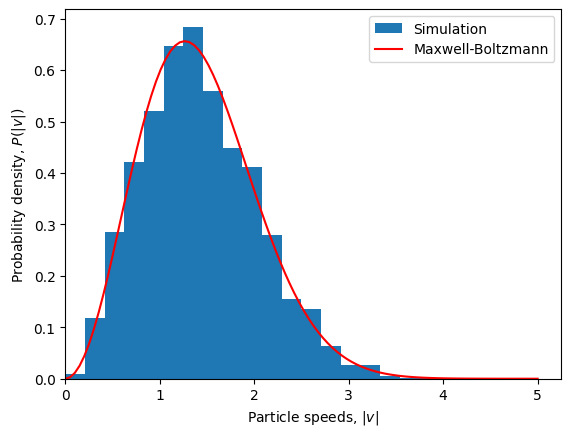

In [12]:
plt.figure()
# Histogram of particle speeds
vel = configuration['v']
speeds = np.linalg.norm(vel, axis=1)
bins = np.linspace(0, 5, 25)
plt.hist(speeds, bins=bins, density=True, label='Simulation')
# Theoretical Maxwell-Boltzmann distribution
v = np.linspace(0, 5, 100)
maxwell_boltzmann = (2*np.pi*temperature)**(-3/2)*4*np.pi*v**2*np.exp(-v**2/(2*temperature))
plt.plot(v, maxwell_boltzmann, label='Maxwell-Boltzmann', color='r')
# Plot settings
plt.xlabel(r'Particle speeds, $|v|$')
plt.ylabel(r'Probability density, $P(|v|)$')
plt.xlim(0, None)
plt.legend()
plt.show()

## Pair potential
Next, we set up the Lennard-Jones pair potential. We use the 12-6 Lennard-Jones potential

$$
  v_\infty(r) = 4\varepsilon \left[\left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6}\right]
$$

(the substript refer to a "truncation" at $\infty$). Here $\sigma$ (`sigma`) is length, and $\varepsilon$ (`epsilon`) is an energy. We will use Lennard-Jones units, where $\sigma = 1$ and $\varepsilon = 1$.

Several pair potentials functions are implemented in `rumdpy`, and the above 12-6 Lennard-Jones potential is implemented as `rp.LJ_12_6_sigma_epsilon`. This is a Python function that takes distances, parameters as input and returns the potential energy, the force and the second derivative of the potential energy.

Let us confirm values are as expected in the minimum of the potential:

\begin{align}
  r_{min} &= 2^{1/6} \\
  v(r_{min}) &= -\varepsilon \\
  f(r_{min}) &= 0 \\
  \left.\frac{d^2v}{dr^2}\right|_{r_{min}} &= (624\cdot2^{-7/3}-168\cdot2^{-4/3})\frac{\varepsilon}{\sigma^2} \simeq 57.146\frac{\varepsilon}{\sigma^2}
\end{align}


In [13]:
pair_raw = rp.LJ_12_6_sigma_epsilon  # Pair potential function (raw)
r_min = 2**(1/6)
u_min, f_min, curvature_min = pair_raw(r_min, (1.0, 1.0, np.inf))
u_min, f_min, curvature_min

(-1.0, -2.1148430366511475e-15, 57.146437870855145)


To allow for a $O(N)$ algorithm for force calculations, we truncate the pair potential at radius of $r_c = 2.5\sigma$ (`cutoff`). The potential is shifted to zero at the cutoff radius, so the actual potential is

$$
  v(r) = v_\infty(r) - v_\infty(r_c)
$$

For convenience, we can use the `rp.apply_shifted_potential_cutoff` function.

In [14]:
pair_func = rp.apply_shifted_potential_cutoff(rp.LJ_12_6_sigma_epsilon)

We can now create an interaction objects using this pair potential function. 

In [15]:
sigma, epsilon, cutoff = 1.0, 1.0, 2.5
pair_pot = rp.PairPotential2(pair_func, params=[sigma, epsilon, cutoff], max_num_nbs=1000)

This object contains a method for plotting the potential.

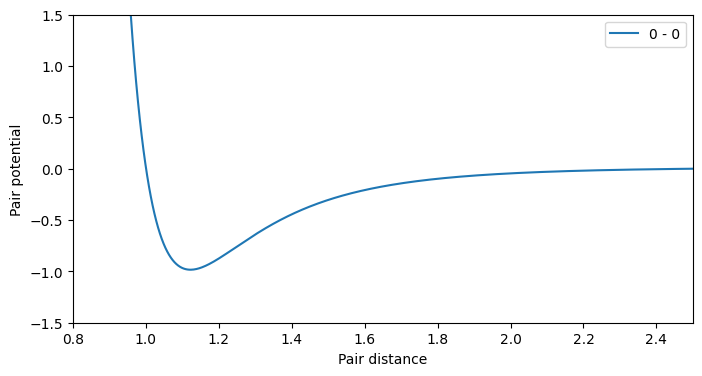

In [16]:
pair_pot.plot(xlim=(0.8, 2.5), ylim=(-1.5, 1.5))

## Integrator

Next, create an integrator object. These are avalible in the submodule `rumdpy.integrators`. Here, we chose to use and implementation of the Nosé-Hoover thermostat discretised using the Leap-Frog scheme. We set a time-step of $dt=0.005$ and a thermostat relaxation time to $\tau = 0.2$ (both in Lennard-Jones units).

In [17]:
# Setup integrator: Nosé-Hoover NVT, Leap-frog algorithm
integrator = rp.integrators.NVT(temperature=temperature, tau=0.2, dt=0.005)

## The Simulation object

We now have all the components to set up a simulation object.

* An configuration object (particle positions, velocities, masses, ...).
* An interaction object with the Lennard-Jones potential.
* An integrator object with the Nosé-Hoover thermostat.

For the simulation object we also specify that we want ten time blocks of one thousand steps. We also specify that we want to store the simulation data in memory (alternatively, data can be stored to the disk for later analysis). To avoid numerical issues, we reset the momenta every 100 steps. Here, we store the simulation data in memory (alternatively, data can be stored to the disk for later analysis).

In [18]:
# Setup Simulation. 
sim = rp.Simulation(
    configuration=configuration,
    interactions=pair_pot,
    integrator=integrator,
    steps_between_momentum_reset=100,
    num_timeblocks=10,
    steps_per_timeblock=1000,
    storage='memory'
)

Storing results in memory. Expected footprint  5.16 MB.


Finally, we run the simulation using the `run` method. Some basic information will be displayed.

In [19]:
sim.run()  # Run simulation

time= 0.000     u= -6.162    w= 1.402     lap= 1047.071  m= 1.000     k= 1.192     fsq= 837.199   
time= 5.000     u= -6.111    w= 1.670     lap= 1070.411  m= 1.000     k= 1.218     fsq= 899.537   
time= 10.000    u= -6.147    w= 1.485     lap= 1054.283  m= 1.000     k= 1.160     fsq= 837.353   
time= 15.000    u= -6.164    w= 1.394     lap= 1046.250  m= 1.000     k= 1.180     fsq= 813.281   
time= 20.000    u= -6.190    w= 1.236     lap= 1032.987  m= 1.000     k= 1.208     fsq= 797.887   
time= 25.000    u= -6.167    w= 1.385     lap= 1045.179  m= 1.000     k= 1.177     fsq= 793.197   
time= 30.000    u= -6.188    w= 1.256     lap= 1034.772  m= 1.000     k= 1.221     fsq= 827.821   
time= 35.000    u= -6.135    w= 1.552     lap= 1060.506  m= 1.000     k= 1.187     fsq= 873.682   
time= 40.000    u= -6.164    w= 1.387     lap= 1046.194  m= 1.000     k= 1.168     fsq= 847.618   
time= 45.000    u= -6.131    w= 1.575     lap= 1062.152  m= 1.000     k= 1.227     fsq= 879.194   
Particles 

The sim methods prints some basic information after each timeblock and summary.

Congratulations! You have now setup and executed your first simulation with `rumdpy`. You are now ready to continue with more advanced simulations and analysis.